In [129]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf, concat, to_timestamp,to_date, to_timestamp, sum, dayofweek, abs as spark_abs, when, count
from pyspark.sql.functions import month, when, substring, mean, round, concat_ws, lit, unix_timestamp, date_format, row_number, expr, avg, weekofyear
from pyspark.sql.functions import year, lag, lead, from_unixtime, last, first, count,lpad, trim, regexp_replace,  monotonically_increasing_id
from pyspark.sql.types import IntegerType, TimestampType, StringType, StructType, StructField, IntegerType, DoubleType, DateType,FloatType,BinaryType
from pyspark.sql import Row
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler,VectorAssembler,OneHotEncoder,StringIndexer
from pyspark.ml.linalg import DenseVector
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor, DecisionTreeRegressor,RandomForestRegressor
from xgboost.spark import SparkXGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from xgboost import plot_importance
import json
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark
import os
import sys
from datetime import datetime, timedelta, date
import findspark 
import pytz
findspark.init()
findspark.find()
#os.chdir("C:/Users/boypa/OneDrive - The University of Auckland/INFOSYS 722/Project/Assignment 4")
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

***
<span style="font-size:18px; color:red;">Data Preparation</span><br>
***

In [2]:
#create session
spark = SparkSession.builder \
    .appName("Electricity Consumption Forecast") \
    .config("spark.sql.session.timeZone", "UTC+12:00") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()


In [3]:
#put observations from 1095 csv files to a datframe
#function from TP to time
def tp_to_time(n):
    hours = (n - 1) // 2
    minutes = 30 * ((n - 1) % 2)
    t = timedelta(hours=hours, minutes=minutes)
    return t

#create udf
tp_to_time_udf = udf(lambda n: tp_to_time(n), TimestampType())

In [ ]:
# Directories and file lists [DO NOT EVALUATE, THIS ONLY SHOW HOW I GET THE DATA FROM ROCESSING MULTIPLE CSVS]
# Merge Daily Data into Yearly Dataframe and write it to csv 
dir = "C:/Users/boypa/OneDrive - The University of Auckland/Project/Nodal Data"
year = '2023'
file_unavail_list = []
file_avail_list = []
day_number=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']
month_number=['01','02','03','04','05','06','07','08','09','10','11','12']
raw_load_df = spark.createDataFrame([], schema=['Date', 'time', 'TP', 'Load', 'Datetime'])

for month in month_number:
    for day in day_number:
        filename = f'{year}{month}{day}_DispatchNodalPricesAndVolumes.csv'
        file_path = os.path.join(dir, filename)
        datestring = f'{day}/{month}/{year}'
        
        if os.path.exists(file_path):
            file_avail_list.append(filename)
            data = spark.read.csv(file_path, header=True, inferSchema=True)
            entries = data.filter((col('PointOfConnectionCode') == 'HOB1101') & (col('TradingPeriodNumber').between(1, 48))) \
                          .groupBy('TradingPeriodNumber') \
                          .agg({'LoadMegawatts': 'mean'}) \
                          .withColumnRenamed('avg(LoadMegawatts)', 'Load') \
                          .withColumnRenamed('TradingPeriodNumber', 'TP')
            
            if entries.count() == 48:
                entries = entries.withColumn('Date', lit(datestring).cast('date')) \
                                 .withColumn('time', tp_to_time_udf(col('TP'))) \
                                 .withColumn('Datetime', concat(col('Date').cast('string'), lit(' '), col('time').cast('string')).cast(TimestampType()))
                raw_load_df = raw_load_df.union(entries)
            elif entries.count() == 0:
                tp_unavail = list(range(1, 49))
                date_list = [datetime.strptime(datestring, '%d/%m/%Y')] * len(tp_unavail)
                time_list = [tp_to_time(e) for e in tp_unavail]
                dt_list = [d + t for d, t in zip(date_list, time_list)]
                add_entries = spark.createDataFrame(zip(date_list, tp_unavail, time_list, dt_list), schema=['Date', 'TP', 'time', 'Datetime'])
                raw_load_df = raw_load_df.union(add_entries)
            else:
                entries = entries.withColumn('Date', lit(datestring).cast('date')) \
                                 .withColumn('time', tp_to_time_udf(col('TP'))) \
                                 .withColumn('Datetime', concat(col('Date').cast('string'), lit(' '), col('time').cast('string')).cast(TimestampType()))
                
                tpavail = entries.select('TP').rdd.flatMap(lambda x: x).collect()
                tp_unavail = list(set(range(1, 49)) - set(tpavail))
                date_list = [datetime.strptime(datestring, '%d/%m/%Y')] * len(tp_unavail)
                time_list = [tp_to_time(e) for e in tp_unavail]
                dt_list = [d + t for d, t in zip(date_list, time_list)]
                add_entries = spark.createDataFrame(zip(date_list, tp_unavail, time_list, dt_list), schema=['Date', 'TP', 'time', 'Datetime'])
                entries = entries.union(add_entries).orderBy('TP')
                raw_load_df = raw_load_df.union(entries)
        else:
            file_unavail_list.append(filename)
raw_load_df.to_csv(f'dataset/raw_load_df_{year}.csv')

In [4]:
#Load Yearly CSV and combineto_csv
raw_load_df_2021 = spark.read.csv('dataset/raw_load_df_2021.csv', header=True, inferSchema=False)
raw_load_df_2022 = spark.read.csv('dataset/raw_load_df_2022.csv', header=True, inferSchema=False)
raw_load_df_2023 = spark.read.csv('dataset/raw_load_df_2023.csv', header=True, inferSchema=False)
raw_load_df = raw_load_df_2021.union(raw_load_df_2022).union(raw_load_df_2023)
raw_load_check = raw_load_df
#ensure datetime format
raw_load_df = raw_load_df.withColumn('Date', to_date(col('Date'))) \
                         .withColumn('Datetime', to_timestamp('Datetime', 'yyyy-MM-dd HH:mm:ss'))\
                         .withColumn('Load', raw_load_df["Load"].cast("double")) 

In [5]:
#check load df
raw_load_df.show(5)

+---+----------+--------+---+------------------+-------------------+
|_c0|      Date|    time| TP|              Load|           Datetime|
+---+----------+--------+---+------------------+-------------------+
|  0|2021-01-01|00:00:00|  1| 23.41916666666667|2021-01-01 00:00:00|
|  1|2021-01-01|00:30:00|  2|23.409000000000002|2021-01-01 00:30:00|
|  2|2021-01-01|01:00:00|  3|22.638666666666666|2021-01-01 01:00:00|
|  3|2021-01-01|01:30:00|  4|22.132666666666665|2021-01-01 01:30:00|
|  4|2021-01-01|02:00:00|  5|22.240166666666667|2021-01-01 02:00:00|
+---+----------+--------+---+------------------+-------------------+
only showing top 5 rows



In [5]:
#function to check isnull
def check_nulls(df):
    null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
    null_counts.show()
#check null for load data
check_nulls(raw_load_df)

+---+----+----+---+----+--------+
|_c0|Date|time| TP|Load|Datetime|
+---+----+----+---+----+--------+
|  0|   0|   0|  0|1371|       0|
+---+----+----+---+----+--------+



In [7]:
#load data before cleaning
raw_load_df.filter((col("_c0") >= 2999)&(col("_c0") <= 3003)).show(5)

+----+----------+--------+---+------------------+-------------------+
| _c0|      Date|    time| TP|              Load|           Datetime|
+----+----------+--------+---+------------------+-------------------+
|2999|2021-03-04|11:30:00| 24|              NULL|2021-03-04 11:30:00|
|3000|2021-03-04|12:00:00| 25|              NULL|2021-03-04 12:00:00|
|3001|2021-03-04|12:30:00| 26|              NULL|2021-03-04 12:30:00|
|3002|2021-03-04|13:00:00| 27| 38.75133333333333|2021-03-04 13:00:00|
|3003|2021-03-04|13:30:00| 28|38.657833333333336|2021-03-04 13:30:00|
+----+----------+--------+---+------------------+-------------------+
only showing top 5 rows



In [6]:
#add  datetime features
raw_load_df = raw_load_df.withColumn('Day_of_week', dayofweek('Date'))
raw_load_df = raw_load_df.withColumn('Month', month('Date'))
raw_load_df = raw_load_df.withColumn('Is_weekend', when(col('Day_of_week').isin([1, 7]), 1).otherwise(0))
#change time to string
raw_load_df = raw_load_df.withColumn("time", raw_load_df["time"].cast("string"))
raw_load_df = raw_load_df.withColumn('time', substring('time', -8, 8))
#pandas DF for visualization only
raw_load_df_pandas = raw_load_df.toPandas()

(array([19700., 19704., 19708., 19712., 19716., 19720., 19723.]),
 [Text(19700.0, 0, '2023-12-09'),
  Text(19704.0, 0, '2023-12-13'),
  Text(19708.0, 0, '2023-12-17'),
  Text(19712.0, 0, '2023-12-21'),
  Text(19716.0, 0, '2023-12-25'),
  Text(19720.0, 0, '2023-12-29'),
  Text(19723.0, 0, '2024-01-01')])

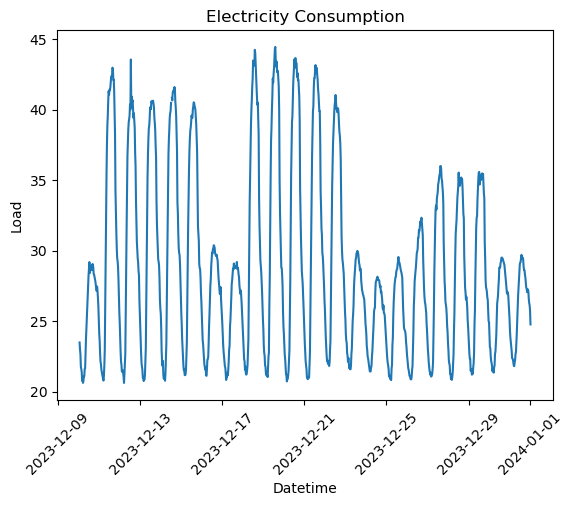

In [11]:
#initial exploration
df_to_vis = raw_load_df.filter(col("Date")>="2023-12-10")
x = np.array(df_to_vis.select("Datetime").collect()).flatten()
y = np.array(df_to_vis.select("Load").collect()).flatten()
plt.plot(x, y, label="Load")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.title("Electricity Consumption")
plt.xticks(rotation=45)

C:\Users\boypa\AppData\Local\Temp\ipykernel_430356\1612355701.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='TP', y='Load', data=raw_load_df_pandas, hue='Day_of_week', ci=None)


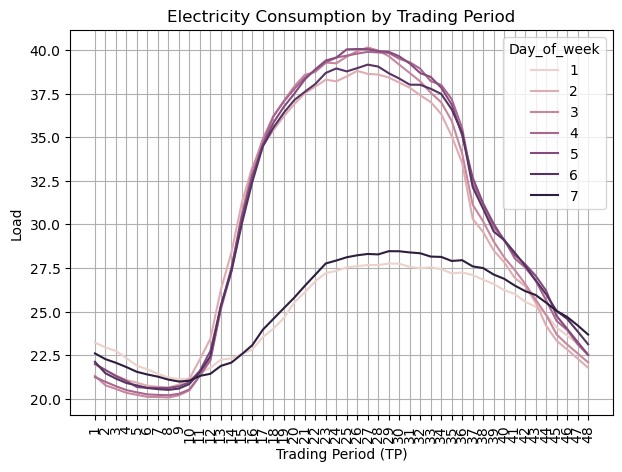

In [10]:
#TP and Load by Day of week
plt.figure(figsize=(7, 5))
plt.xticks(rotation=90)
sns.lineplot(x='TP', y='Load', data=raw_load_df_pandas, hue='Day_of_week', ci=None)
plt.title('Electricity Consumption by Trading Period')
plt.xlabel('Trading Period (TP)')
plt.ylabel('Load')
plt.grid(True)
plt.show()

C:\Users\boypa\AppData\Local\Temp\ipykernel_430356\2928556883.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='TP', y='Load', data=raw_load_df_pandas, hue='Month', ci=None)


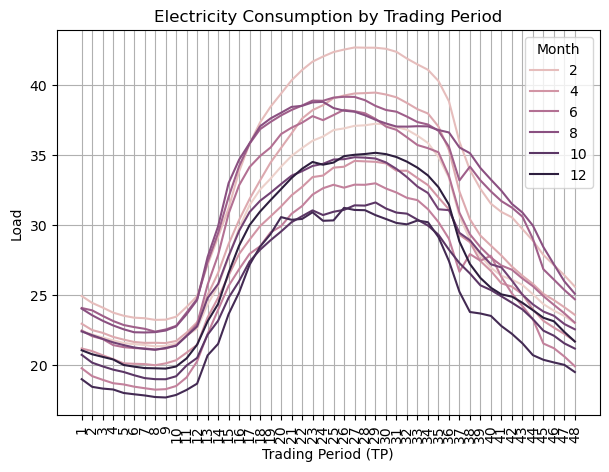

In [11]:
#TP and Load by Month
plt.figure(figsize=(7, 5))
plt.xticks(rotation=90)
sns.lineplot(x='TP', y='Load', data=raw_load_df_pandas, hue='Month', ci=None)
plt.title('Electricity Consumption by Trading Period')
plt.xlabel('Trading Period (TP)')
plt.ylabel('Load')
plt.grid(True)
plt.show()

In [7]:
#create holiday dates
#Add Holiday Table
holiday_2020 = ['01/01/2020','02/01/2020','27/01/2020','06/02/2020','10/04/2020','13/04/2020','25/04/2020','01/06/2020','26/10/2020','25/12/2020','26/12/2020']
holiday_2021 = ['01/01/2021','02/01/2021','04/01/2021','08/02/2021','2/04/2021','5/04/2021','26/04/2021','07/06/2021','25/10/2021','25/12/2021','26/12/2021']
holiday_2022 = ['01/01/2022','03/01/2022','4/01/2022','06/02/2022','15/04/2022','18/04/2022','25/04/2022','06/06/2022','24/06/2022','26/09/2022','24/10/2022','25/12/2022','26/12/2022']
holiday_2023 = ['01/01/2023','02/01/2023','03/01/2023','06/02/2023','7/04/2023','10/04/2023','25/04/2023','05/06/2023','14/07/2023','23/10/2023','25/12/2023','26/12/2023']
holiday_2024 = ['01/01/2024','02/01/2024','29/01/2024','06/02/2024','29/03/2024','01/04/2024','25/04/2024','03/06/2024','28/06/2024','28/10/2024','25/12/2024','26/12/2024']
holiday_dates = holiday_2020 + holiday_2021 + holiday_2022 + holiday_2023 + holiday_2024
holiday_dates_pd = pd.to_datetime(holiday_dates, format="%d/%m/%Y")
holiday_df = pd.DataFrame(holiday_dates_pd, columns=['Date'])
holiday_df['Date'] = holiday_df['Date'].dt.date
holiday_df['Is_holiday'] = 1
#to pyspark DF
holiday_spark_df = spark.createDataFrame(holiday_df)

#merge with main df
raw_load_h_df = raw_load_df.join(holiday_spark_df, 
                               on=raw_load_df['Date'] == holiday_spark_df['Date'], 
                               how='left').drop(holiday_spark_df['Date'])
#is_holiday null to 0
raw_load_h_df = raw_load_h_df.na.fill(value=0, subset=["Is_holiday"])

In [8]:
#fill null with average of the same group
window_spec = Window.partitionBy('Month', 'Day_of_week', 'Is_weekend', 'Is_holiday', 'TP')
mean_load_df = raw_load_h_df.withColumn('mean_load', mean('Load').over(window_spec))
raw_load_filled_df = mean_load_df.withColumn('Load', 
                                             when(col('Load').isNull(), col('mean_load')).otherwise(col('Load'))) \
                                 .drop('mean_load')
#round number and order by date
raw_load_filled_df = raw_load_filled_df.withColumn('Load', round(col('Load'), 2)).orderBy('Datetime')

In [14]:
check_nulls(raw_load_filled_df)

+---+----+----+---+----+--------+-----------+-----+----------+----------+
|_c0|Date|time| TP|Load|Datetime|Day_of_week|Month|Is_weekend|Is_holiday|
+---+----+----+---+----+--------+-----------+-----+----------+----------+
|  0|   0|   0|  0|   0|       0|          0|    0|         0|         0|
+---+----+----+---+----+--------+-----------+-----+----------+----------+



In [15]:
raw_load_filled_df.show(5)

+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
|_c0|      Date|    time| TP| Load|           Datetime|Day_of_week|Month|Is_weekend|Is_holiday|
+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
|  0|2021-01-01|00:00:00|  1|23.42|2021-01-01 00:00:00|          6|    1|         0|         1|
|  1|2021-01-01|00:30:00|  2|23.41|2021-01-01 00:30:00|          6|    1|         0|         1|
|  2|2021-01-01|01:00:00|  3|22.64|2021-01-01 01:00:00|          6|    1|         0|         1|
|  3|2021-01-01|01:30:00|  4|22.13|2021-01-01 01:30:00|          6|    1|         0|         1|
|  4|2021-01-01|02:00:00|  5|22.24|2021-01-01 02:00:00|          6|    1|         0|         1|
+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
only showing top 5 rows



In [16]:
#check sample for comparison
raw_load_filled_df.filter((col("_c0") >= 2999)&(col("_c0") <= 3003)).show(5)

+----+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
| _c0|      Date|    time| TP| Load|           Datetime|Day_of_week|Month|Is_weekend|Is_holiday|
+----+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
|2999|2021-03-04|11:30:00| 24|40.91|2021-03-04 11:30:00|          5|    3|         0|         0|
|3000|2021-03-04|12:00:00| 25|42.05|2021-03-04 12:00:00|          5|    3|         0|         0|
|3001|2021-03-04|12:30:00| 26| 42.3|2021-03-04 12:30:00|          5|    3|         0|         0|
|3002|2021-03-04|13:00:00| 27|38.75|2021-03-04 13:00:00|          5|    3|         0|         0|
|3003|2021-03-04|13:30:00| 28|38.66|2021-03-04 13:30:00|          5|    3|         0|         0|
+----+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
only showing top 5 rows



In [9]:
# Load weather data
#---weather table---#
auckland_weather_DP = spark.read.option("header", "true").option("inferSchema", "true").csv('dataset/auckland_weather_DP_output1.csv')
auckland_weather_check = auckland_weather_DP
auckland_weather_DP = auckland_weather_DP.select(col('datetime'), col('temp'), col('humidity'))
#convert to datetime, remove duplicates
auckland_weather_DP = auckland_weather_DP.withColumn("datetime", unix_timestamp(col("datetime"), 'dd/MM/yyyy HH:mm').cast("timestamp"))
auckland_weather_DP = auckland_weather_DP.dropDuplicates(["datetime"]).orderBy('datetime')
#duplicate row and add 30 minutes then concate
auckland_weather_DP_r_copy = auckland_weather_DP.withColumn("datetime", col("datetime") + expr("INTERVAL 30 MINUTES"))
auckland_weather = auckland_weather_DP.union(auckland_weather_DP_r_copy)
#ensure proper date and less than 2023
auckland_weather = auckland_weather.withColumn("Date", date_format(col("datetime"), "yyyy-MM-dd").cast("date"))
auckland_weather_2020to2023 = auckland_weather.filter(year(col("Date")) <= 2023)

In [18]:
#check weather data before cleaning
auckland_weather_check.show(5)

+----------------+----+--------+---------+------+----------+----------+----+---------+--------+---------+-------+
|        datetime|temp|humidity|feelslike|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|
+----------------+----+--------+---------+------+----------+----------+----+---------+--------+---------+-------+
|01/01/2021 00:00|16.0|   86.88|     16.0|   0.0|         0|      NULL|   0|        0|    11.5|      4.1|  250.0|
|01/01/2021 01:00|16.4|   90.02|     16.4|   0.0|         0|      NULL|   0|        0|    11.9|      4.1|  184.0|
|01/01/2021 02:00|15.7|   90.02|     15.7|   0.0|         0|      NULL|   0|        0|    11.9|      7.4|  270.0|
|01/01/2021 03:00|15.8|   90.99|     15.8|   0.0|         0|      NULL|   0|        0|    11.5|      1.8|  324.0|
|01/01/2021 04:00|14.8|   94.85|     14.8|   0.0|         0|      NULL|   0|        0|    11.2|      3.5|   20.0|
+----------------+----+--------+---------+------+----------+----------+----+---------+--

In [19]:
#check nulls weather data
check_nulls(auckland_weather_2020to2023)

+--------+----+--------+----+
|datetime|temp|humidity|Date|
+--------+----+--------+----+
|       0|   0|       0|   0|
+--------+----+--------+----+



In [20]:
#check duplicates weather data before cleaning
auckland_weather_check.groupBy("datetime").agg(count("*").alias("count")).filter(col("count") > 1).count()

3

In [21]:
#check duplicates weather data after cleaning
auckland_weather_2020to2023.groupBy("datetime").agg(count("*").alias("count")).filter(col("count") > 1).count()

0

In [10]:
#Check Data Consistencies and Do Cleaning for Integration
#load data time consistency
window_spec1 = Window.orderBy("timestamp")
raw_load_filled_df = raw_load_filled_df.withColumn('timestamp', unix_timestamp('Datetime', 'dd-MMyyyy HH:mm:ss'))
raw_load_filled_df = raw_load_filled_df.withColumn('time_diff', (lead('timestamp', 1).over(window_spec1) - col('timestamp')) / 60)
raw_load_filled_df.filter('time_diff != 30').show()
#remove timediff and timestamp cols
raw_load_filled_df = raw_load_filled_df.drop('timestamp','time_diff')

+---+----+----+---+----+--------+-----------+-----+----------+----------+---------+---------+
|_c0|Date|time| TP|Load|Datetime|Day_of_week|Month|Is_weekend|Is_holiday|timestamp|time_diff|
+---+----+----+---+----+--------+-----------+-----+----------+----------+---------+---------+
+---+----+----+---+----+--------+-----------+-----+----------+----------+---------+---------+



In [23]:
raw_load_filled_df.show(5)

+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
|_c0|      Date|    time| TP| Load|           Datetime|Day_of_week|Month|Is_weekend|Is_holiday|
+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
|  0|2021-01-01|00:00:00|  1|23.42|2021-01-01 00:00:00|          6|    1|         0|         1|
|  1|2021-01-01|00:30:00|  2|23.41|2021-01-01 00:30:00|          6|    1|         0|         1|
|  2|2021-01-01|01:00:00|  3|22.64|2021-01-01 01:00:00|          6|    1|         0|         1|
|  3|2021-01-01|01:30:00|  4|22.13|2021-01-01 01:30:00|          6|    1|         0|         1|
|  4|2021-01-01|02:00:00|  5|22.24|2021-01-01 02:00:00|          6|    1|         0|         1|
+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
only showing top 5 rows



In [11]:
#weather data time consistency
auckland_weather_2020to2023 = auckland_weather_2020to2023.withColumn('timestamp', unix_timestamp('datetime'))
window_spec1 = Window.orderBy("timestamp")
auckland_weather_2020to2023 = auckland_weather_2020to2023.withColumn('timestamp', unix_timestamp('datetime', 'dd-MMyyyy HH:mm:ss'))
auckland_weather_2020to2023 = auckland_weather_2020to2023.withColumn('time_diff', (lead('timestamp', 1).over(window_spec1) - col('timestamp')) / 60)
auckland_weather_2020to2023.filter('time_diff != 30').show()
auckland_weather_2020to2023 = auckland_weather_2020to2023.drop('timestamp', 'time_diff')

+-------------------+----+--------+----------+----------+---------+
|           datetime|temp|humidity|      Date| timestamp|time_diff|
+-------------------+----+--------+----------+----------+---------+
|2021-09-26 01:30:00|13.9|   88.38|2021-09-26|1632576600|     90.0|
|2022-09-25 01:30:00|14.1|   79.27|2022-09-25|1664026200|     90.0|
|2023-09-24 01:30:00|15.5|   97.61|2023-09-24|1695475800|     90.0|
+-------------------+----+--------+----------+----------+---------+



In [12]:
#Make Sure the same datetime length 
datetime_df =  raw_load_filled_df.select(col("Datetime"))
auckland_weather_2020to2023 = auckland_weather_2020to2023.withColumnRenamed('datetime', 'dtw')
auckland_weather_2020to2023_tm =auckland_weather_2020to2023.join(datetime_df,
    auckland_weather_2020to2023['dtw'] == datetime_df['Datetime'],how='right')
#drop after merge
auckland_weather_2020to2023_tm = auckland_weather_2020to2023_tm.drop('dtw', 'Date')
#bfill null values
w_backward = Window.partitionBy().orderBy('Datetime').rowsBetween(Window.currentRow,Window.unboundedFollowing)
auckland_weather_2020to2023_tm = auckland_weather_2020to2023_tm.withColumn('temp',first('temp',ignorenulls=True).over(w_backward))
auckland_weather_2020to2023_tm = auckland_weather_2020to2023_tm.withColumn('humidity',first('humidity',ignorenulls=True).over(w_backward))

In [26]:
raw_load_filled_df.show(5)

+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
|_c0|      Date|    time| TP| Load|           Datetime|Day_of_week|Month|Is_weekend|Is_holiday|
+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
|  0|2021-01-01|00:00:00|  1|23.42|2021-01-01 00:00:00|          6|    1|         0|         1|
|  1|2021-01-01|00:30:00|  2|23.41|2021-01-01 00:30:00|          6|    1|         0|         1|
|  2|2021-01-01|01:00:00|  3|22.64|2021-01-01 01:00:00|          6|    1|         0|         1|
|  3|2021-01-01|01:30:00|  4|22.13|2021-01-01 01:30:00|          6|    1|         0|         1|
|  4|2021-01-01|02:00:00|  5|22.24|2021-01-01 02:00:00|          6|    1|         0|         1|
+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
only showing top 5 rows



In [13]:
#weather data consistency after cleaning
auckland_weather_2020to2023_tm = auckland_weather_2020to2023_tm.withColumn('timestamp', unix_timestamp('datetime'))
window_spec1 = Window.orderBy("timestamp")
auckland_weather_2020to2023_tm = auckland_weather_2020to2023_tm.withColumn('timestamp', unix_timestamp('datetime', 'dd-MMyyyy HH:mm:ss'))
auckland_weather_2020to2023_tm = auckland_weather_2020to2023_tm.withColumn('time_diff', (lead('timestamp', 1).over(window_spec1) - col('timestamp')) / 60)
auckland_weather_2020to2023_tm.filter('time_diff != 30').show()
auckland_weather_2020to2023_tm = auckland_weather_2020to2023_tm.drop('timestamp', 'time_diff')

+----+--------+--------+---------+---------+
|temp|humidity|Datetime|timestamp|time_diff|
+----+--------+--------+---------+---------+
+----+--------+--------+---------+---------+



In [28]:
#check columns
auckland_weather_2020to2023_tm.printSchema()
raw_load_filled_df.printSchema()

root
 |-- temp: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- Datetime: timestamp (nullable = true)

root
 |-- _c0: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- TP: string (nullable = true)
 |-- Load: double (nullable = true)
 |-- Datetime: timestamp (nullable = true)
 |-- Day_of_week: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Is_weekend: integer (nullable = false)
 |-- Is_holiday: long (nullable = true)



In [29]:
raw_load_filled_df.show()

+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
|_c0|      Date|    time| TP| Load|           Datetime|Day_of_week|Month|Is_weekend|Is_holiday|
+---+----------+--------+---+-----+-------------------+-----------+-----+----------+----------+
|  0|2021-01-01|00:00:00|  1|23.42|2021-01-01 00:00:00|          6|    1|         0|         1|
|  1|2021-01-01|00:30:00|  2|23.41|2021-01-01 00:30:00|          6|    1|         0|         1|
|  2|2021-01-01|01:00:00|  3|22.64|2021-01-01 01:00:00|          6|    1|         0|         1|
|  3|2021-01-01|01:30:00|  4|22.13|2021-01-01 01:30:00|          6|    1|         0|         1|
|  4|2021-01-01|02:00:00|  5|22.24|2021-01-01 02:00:00|          6|    1|         0|         1|
|  5|2021-01-01|02:30:00|  6|22.06|2021-01-01 02:30:00|          6|    1|         0|         1|
|  6|2021-01-01|03:00:00|  7|21.56|2021-01-01 03:00:00|          6|    1|         0|         1|
|  7|2021-01-01|03:30:00|  8|21.68|2021-

In [14]:
#Integration
main_df = raw_load_filled_df.join(auckland_weather_2020to2023_tm, on='Datetime', how='left').orderBy('Datetime') \
        .withColumnRenamed('_c0', 'idx')
main_df.show(5)

+-------------------+---+----------+--------+---+-----+-----------+-----+----------+----------+----+--------+
|           Datetime|idx|      Date|    time| TP| Load|Day_of_week|Month|Is_weekend|Is_holiday|temp|humidity|
+-------------------+---+----------+--------+---+-----+-----------+-----+----------+----------+----+--------+
|2021-01-01 00:00:00|  0|2021-01-01|00:00:00|  1|23.42|          6|    1|         0|         1|16.0|   86.88|
|2021-01-01 00:30:00|  1|2021-01-01|00:30:00|  2|23.41|          6|    1|         0|         1|16.0|   86.88|
|2021-01-01 01:00:00|  2|2021-01-01|01:00:00|  3|22.64|          6|    1|         0|         1|16.4|   90.02|
|2021-01-01 01:30:00|  3|2021-01-01|01:30:00|  4|22.13|          6|    1|         0|         1|16.4|   90.02|
|2021-01-01 02:00:00|  4|2021-01-01|02:00:00|  5|22.24|          6|    1|         0|         1|15.7|   90.02|
+-------------------+---+----------+--------+---+-----+-----------+-----+----------+----------+----+--------+
only showi

In [20]:
#scale transfomation 
assembler = VectorAssembler(inputCols=["Load"], outputCol="Load_vec")
scaler = MinMaxScaler(inputCol="Load_vec", outputCol="Load_scaled")
pipeline = Pipeline(stages=[assembler, scaler])
scalerModel = pipeline.fit(main_df)
scaledData = scalerModel.transform(main_df)

In [32]:
scaledData.drop('date', 'datetime').show(5)

+---+--------+---+-----+-----------+-----+----------+----------+----+--------+--------+--------------------+
|idx|    time| TP| Load|Day_of_week|Month|Is_weekend|Is_holiday|temp|humidity|Load_vec|         Load_scaled|
+---+--------+---+-----+-----------+-----+----------+----------+----+--------+--------+--------------------+
|  0|00:00:00|  1|23.42|          6|    1|         0|         1|16.0|   86.88| [23.42]|[0.32787344253114...|
|  1|00:30:00|  2|23.41|          6|    1|         0|         1|16.0|   86.88| [23.41]|[0.32773344533109...|
|  2|01:00:00|  3|22.64|          6|    1|         0|         1|16.4|   90.02| [22.64]|[0.31695366092678...|
|  3|01:30:00|  4|22.13|          6|    1|         0|         1|16.4|   90.02| [22.13]|[0.3098138037239255]|
|  4|02:00:00|  5|22.24|          6|    1|         0|         1|15.7|   90.02| [22.24]|[0.31135377292454...|
+---+--------+---+-----+-----------+-----+----------+----------+----+--------+--------+--------------------+
only showing top 5 

<Axes: xlabel='temp_c', ylabel='Load'>

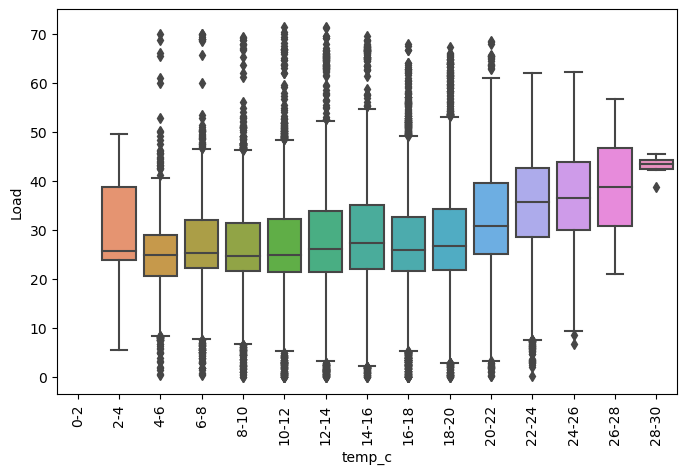

In [33]:
#temperature vs Load
binned_temp_df = main_df.toPandas()
temp_bin = list(range(0,31,2))
binned_temp_df['temp_c'] = pd.cut(binned_temp_df['temp'], bins=temp_bin, labels=[f'{e}-{e+2}' for e in temp_bin[:-1]])
plt.figure(figsize=(8,5))
plt.xticks(rotation=90)
sns.boxplot(x='temp_c', y='Load', data=binned_temp_df)

In [21]:
#Add time-lag features
#pivot wide TP 
main_TP_wide_df = main_df.groupBy("Date").pivot("TP").sum("Load")
#create time lag-features
window_spec = Window.orderBy("Date")
for col_name in main_TP_wide_df.columns[1:]:
    main_TP_wide_df = main_TP_wide_df.withColumn(f"P{col_name}", lag(col(col_name), 1).over(window_spec))
#order columns
tplist = [str(e) for e in range(1,49)]
plist = [f"P{e}" for e in range(1,49)]
cols = tplist+plist
main_TP_wide_df = main_TP_wide_df.select(cols).dropna()

In [16]:
#create correlation matrix and visualize
vector_col = "variables"
assembler = VectorAssembler(inputCols=cols, outputCol=vector_col)
main_TP_vect = assembler.transform(main_TP_wide_df).select(vector_col)
#correlation matrix
cormat = Correlation.corr(main_TP_vect, vector_col).collect()[0][0]
#to dense matrix
cormat_array = cormat.toArray()

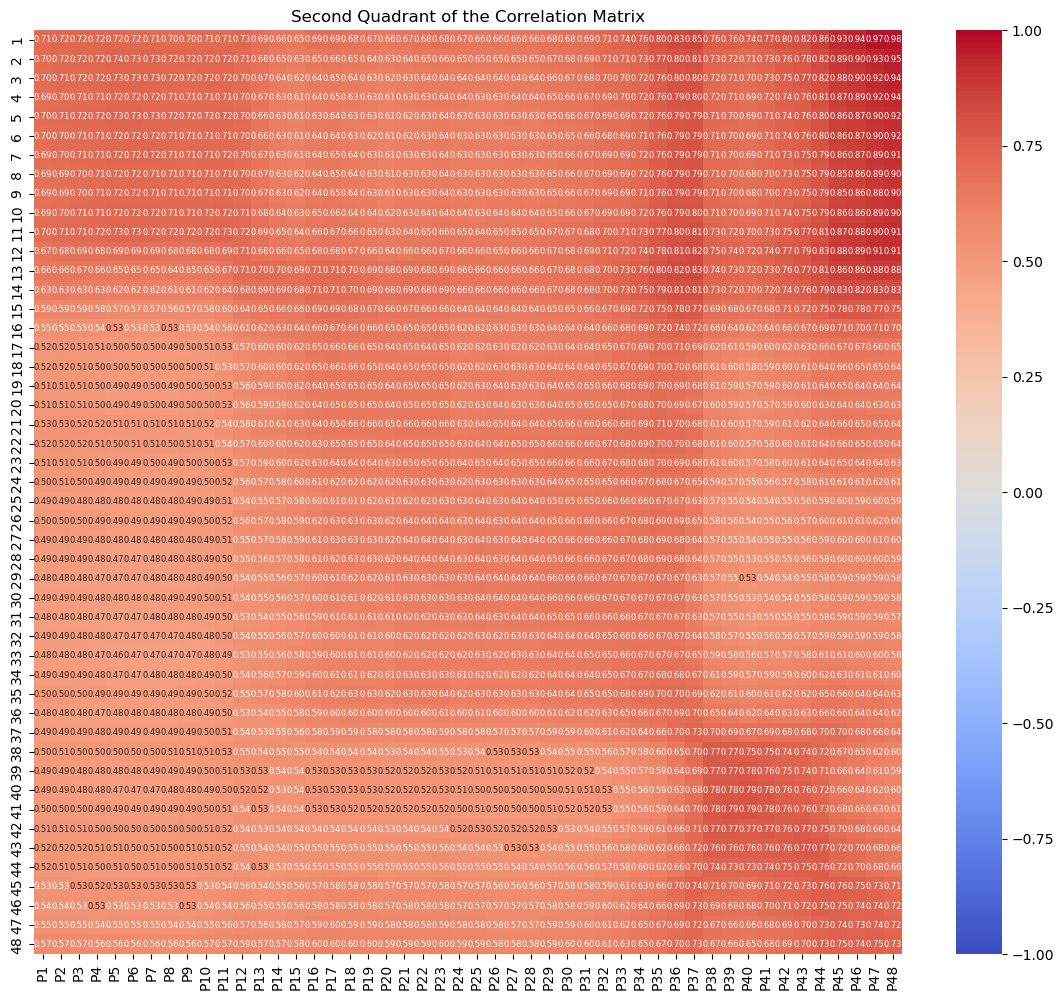

In [17]:
#visualize, focus only second quadrant
matrix_size = cormat_array.shape[0]
half_size = matrix_size // 2
second_quadrant = cormat_array[:half_size, half_size:]

plt.figure(figsize=(14, 12))
sns.heatmap(second_quadrant, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            xticklabels=cols[half_size:], yticklabels=cols[:half_size],fmt='.2f',annot_kws={'size':6})
plt.title("Second Quadrant of the Correlation Matrix")
plt.show()

In [15]:
#Add previous holiday information features
w = Window.orderBy("Datetime")
main_df = main_df.withColumn("Is_holiday_prev", lag("Is_holiday", 48).over(w))

In [38]:
main_df.dropna().show(5)

+-------------------+---+----------+--------+---+-----+-----------+-----+----------+----------+----+--------+---------------+
|           Datetime|idx|      Date|    time| TP| Load|Day_of_week|Month|Is_weekend|Is_holiday|temp|humidity|Is_holiday_prev|
+-------------------+---+----------+--------+---+-----+-----------+-----+----------+----------+----+--------+---------------+
|2021-01-02 00:00:00| 48|2021-01-02|00:00:00|  1|22.79|          7|    1|         1|         1|18.0|    87.5|              1|
|2021-01-02 00:30:00| 49|2021-01-02|00:30:00|  2|22.69|          7|    1|         1|         1|18.0|    87.5|              1|
|2021-01-02 01:00:00| 50|2021-01-02|01:00:00|  3|21.94|          7|    1|         1|         1|17.8|   88.79|              1|
|2021-01-02 01:30:00| 51|2021-01-02|01:30:00|  4|21.56|          7|    1|         1|         1|17.8|   88.79|              1|
|2021-01-02 02:00:00| 52|2021-01-02|02:00:00|  5|21.08|          7|    1|         1|         1|18.0|   88.19|         

***
<span style="font-size:18px; color:red;">Model Development and Evaluation</span><br>
***

In [16]:
#create multiple target and time-lag features for both scnearios
#scenario1: use strongest correlated
#scenario2: use multiple time-lag features
df_list = {}
w = Window.orderBy("Date")
load_48 = main_df.filter(col('TP')==48).select('Date','Load')
load_48_prev = load_48.withColumn('Lag_a', lag('Load', 1).over(w))
load_48_prev = load_48_prev.select('Date','Lag_a')
for i in range(1,49) :
    df_list[i] = main_df.filter(col('TP')==i)
    if i<=16 :
        df_list[i] = df_list[i].join(load_48_prev, on="Date", how="inner").withColumnRenamed('Lag_a','Lag_1')
        df_list[i] = df_list[i].withColumn('Lag_2', lag('Load', 1).over(w))
    else:
        df_list[i] = df_list[i].join(load_48_prev, on="Date", how="inner").withColumnRenamed('Lag_a','Lag_2')
        df_list[i] = df_list[i].withColumn('Lag_1', lag('Load', 1).over(w))

In [40]:
df_list[1].drop('Datetime').show(5)

+----------+---+--------+---+-----+-----------+-----+----------+----------+----+--------+---------------+-----+-----+
|      Date|idx|    time| TP| Load|Day_of_week|Month|Is_weekend|Is_holiday|temp|humidity|Is_holiday_prev|Lag_2|Lag_1|
+----------+---+--------+---+-----+-----------+-----+----------+----------+----+--------+---------------+-----+-----+
|2021-01-01|  0|00:00:00|  1|23.42|          6|    1|         0|         1|16.0|   86.88|           NULL| NULL| NULL|
|2021-01-02| 48|00:00:00|  1|22.79|          7|    1|         1|         1|18.0|    87.5|              1|23.42|22.78|
|2021-01-03| 96|00:00:00|  1|22.83|          1|    1|         1|         0|17.1|    99.3|              1|22.79|22.77|
|2021-01-04|144|00:00:00|  1|22.26|          2|    1|         0|         1|19.0|   92.91|              0|22.83|22.97|
|2021-01-05|192|00:00:00|  1|22.34|          3|    1|         0|         0|18.9|    88.2|              1|22.26|23.29|
+----------+---+--------+---+-----+-----------+-----+---

In [ ]:
#HyperParameter tuning with spark ML tuning (similar to GridsearchCV)
#[---WARNING---]
#This part take a lot of time to finish as pyspark ML tuning was primarily made for paralel/multiple GPU training 
#Safe to assume that this give the same result from iteration 3 
best_params = {}
features_in = ['Lag_2','Day_of_week','Month','Is_holiday','Is_holiday_prev','temp','humidity']
for i in range(1,49) :
    train_data = df_list[i].filter(year(col("Datetime"))<=2022).dropna()
    xgb = SparkXGBRegressor(features_col=features_in, label_col="Load",  device="cuda")
    paramGrid = (ParamGridBuilder()
             .addGrid(xgb.learning_rate, [0.01, 0.1, 0.2])
             .addGrid(xgb.max_depth, [3, 5, 7])
             .addGrid(xgb.reg_lambda, [0.1, 1, 10])
             .build())
    evaluator = RegressionEvaluator(labelCol="Load", predictionCol="prediction", metricName="rmse")
    crossval = CrossValidator(estimator=xgb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  
    cvModel = crossval.fit(train_data)
    best_params[i] = [cvModel.bestModel.getOrDefault('learning_rate'),cvModel.bestModel.getOrDefault('max_depth'),
                     cvModel.bestModel.getOrDefault('reg_lambda')]
    
#save best param to json   
with open('dataset/bestparams.json', 'w') as json_file:
    json.dump(bestparams, json_file)

2024-05-18 00:00:05,014 WARNING SparkXGBRegressor: _validate_gpu_params You have enabled GPU in spark local mode. Please make sure your local node has at least 1 GPUs
2024-05-18 00:01:34,800 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cuda', 'learning_rate': 0.01, 'max_depth': 3, 'objective': 'reg:squarederror', 'reg_lambda': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-05-18 00:01:34,981 INFO SparkXGBRegressor: _skip_stage_level_scheduling Stage-level scheduling in xgboost requires spark standalone or local-cluster mode
2024-05-18 00:01:41,392 INFO XGBoost-PySpark: _fit Finished xgboost training!


In [24]:
#Prediction function with SparkXGBoostRegressor model
def xgb_model(df,features,params):
    data = df.dropna()
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    data = assembler.transform(data)
    #split
    train_data = data.filter(year(col("Date")) <= 2022)
    test_data = data.filter(year(col("Date")) > 2022)
    
    #create model
    xgb_regressor = SparkXGBRegressor(
    features_col="features",
    label_col="Load",
    device="cuda",
    objective='reg:squarederror',
    num_round=50,
    learning_rate=params['eta'],
    max_depth=params['max_depth'],
    reg_lambda=params['lambda'],
    verbosity=0)
    #train
    xgb_model = xgb_regressor.fit(train_data) 
    #predict
    predictions = xgb_model.transform(test_data)
    
    return predictions

***Model XGB1: Time-lag Feature Scenario 1 and Without Parameter Tuning*** 

In [ ]:
#Do predictions  for TP1 to TP48 -- First attempt
#Export each to csv to avoid loosing data in the process as it took sometime to complete all prediction target 
features_in = ['Lag_1','Day_of_week','Month','Is_holiday','Is_holiday_prev','temp','humidity']
for i in range(1,49):
    print(f'Start training and testing for TP{i}')
    df = df_list[i]
    params={'eta': 0.3, 'lambda': 0, 'max_depth': 6}
    xgb_pred_0 = xgb_model(df,features_in,params)
    df_to_merge_0 = xgb_pred_0.select('prediction','TP','Date')
    df_to_merge_0.toPandas().to_csv(f'predictions/0_xgb_pred{i}.csv')
    print(f'Finish training and testing for TP{i}')

In [94]:
#retrieve multiple prediction target, merge to a df
main_xgb_pred_df = main_df.filter(year(col('Date'))>2022)
schema = StructType([
    StructField("Date", DateType(), True),
    StructField("TP", IntegerType(), True),
    StructField("prediction", DoubleType(), True)])
df_tomerge = spark.createDataFrame([], schema)
for i in range(1,49):
    df_pred=spark.read.csv(f'predictions/0_xgb_pred{i}.csv', header=True, inferSchema=True).select('Date','TP','prediction')
    df_tomerge=df_tomerge.union(df_pred)
main_xgb_pred_df_0 = main_xgb_pred_df.join(df_tomerge, on=["Date", "TP"], how="left")

In [95]:
#add error columns and calculate overall performance
main_xgb_pred_df_0 = main_xgb_pred_df_0.dropna().withColumn("abs_error", spark_abs(col('Load') - col("prediction")))
main_xgb_pred_df_0 = main_xgb_pred_df_0.dropna().withColumn("absp_error", spark_abs(col('Load') - col("prediction")) / col('Load'))
total_count = main_xgb_pred_df_0.select('prediction').count()
xgb_mape_15_0 = (main_xgb_pred_df_0.filter(col("absp_error") < 0.15).count())/total_count
mae_0 = main_xgb_pred_df_0.select(avg("abs_error")).first()[0]
mape_0 = main_xgb_pred_df_0.select(avg("absp_error")).first()[0]

In [96]:
print(f'MAPE : {mape_0}') #Mean average percentage error
print(f'Proportion APE<15% : {xgb_mape_15_0}') #Proportion of absolute percentage error less than 15%
print(f'MAE : {mae_0}')#Mean Absolute Error

MAPE : 0.2786234633127632
Proportion APE<15% : 0.7535958904109589
MAE : 3.6376502887050246


(array([19417., 19421., 19425., 19429., 19433., 19437.]),
 [Text(19417.0, 0, '2023-03-01'),
  Text(19421.0, 0, '2023-03-05'),
  Text(19425.0, 0, '2023-03-09'),
  Text(19429.0, 0, '2023-03-13'),
  Text(19433.0, 0, '2023-03-17'),
  Text(19437.0, 0, '2023-03-21')])

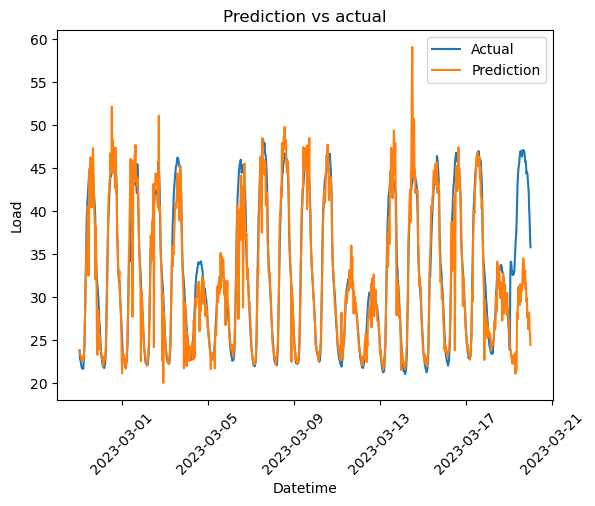

In [108]:
#visualization 
df_to_vis = main_xgb_pred_df_0.filter((weekofyear(col('Datetime'))>=9)&(weekofyear(col('Datetime'))<=11))
x = np.array(df_to_vis.select("Datetime").collect()).flatten()
y1 = np.array(df_to_vis.select("Load").collect()).flatten()
y2 = np.array(df_to_vis.select("prediction").collect()).flatten()
plt.plot(x, y1, label="Actual")
plt.plot(x, y2, label="Prediction")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.title("Prediction vs actual")
plt.legend()
plt.xticks(rotation=45)

***Model XGB2: Time-lag Feature Scenario 1 With Parameter Tuning*** 

In [ ]:
#Do predictions for TP1 to TP48 (Use strongest correlated features and use best parameters) 
#Export each to csv to avoid loosing data in the process as it took sometime to complete all prediction target 
features_in = ['Lag_1','Day_of_week','Month','Is_holiday','Is_holiday_prev','temp','humidity']
with open('dataset/bestparams.json', 'r') as json_file:
    bestparams = json.load(json_file)
for i in range(1,49):
    print(f'Start training and testing for TP{i}')
    df = df_list[i]
    params=bestparams[f'{i}']
    xgb_pred = xgb_model(df,features_in,params)
    df_to_merge = xgb_pred.select('prediction','TP','Date')
    df_to_merge.toPandas().to_csv(f'predictions/0_1_xgb_pred{i}.csv')
    print(f'Finish training and testing for TP{i}')

In [115]:
#retrieve multiple prediction target, merge to a df
main_xgb_pred_df = main_df.filter(year(col('Date'))>2022)
schema = StructType([
    StructField("Date", DateType(), True),
    StructField("TP", IntegerType(), True),
    StructField("prediction", DoubleType(), True)])
df_tomerge = spark.createDataFrame([], schema)
for i in range(1,49):
    df_pred=spark.read.csv(f'predictions/0_1_xgb_pred{i}.csv', header=True, inferSchema=True).select('Date','TP','prediction')
    df_tomerge=df_tomerge.union(df_pred)
main_xgb_pred_df_0_1 = main_xgb_pred_df.join(df_tomerge, on=["Date", "TP"], how="left")

In [116]:
#add error columns and calculate overall performance
main_xgb_pred_df_0_1 = main_xgb_pred_df_0_1.dropna().withColumn("abs_error", spark_abs(col('Load') - col("prediction")))
main_xgb_pred_df_0_1 = main_xgb_pred_df_0_1.dropna().withColumn("absp_error", spark_abs(col('Load') - col("prediction")) / col('Load'))
total_count = main_xgb_pred_df_0_1.select('prediction').count()
xgb_mape_15_0_1 = (main_xgb_pred_df_0_1.filter(col("absp_error") < 0.15).count())/total_count
mae_0_1 = main_xgb_pred_df_0_1.select(avg("abs_error")).first()[0]
mape_0_1 = main_xgb_pred_df_0_1.select(avg("absp_error")).first()[0]

In [117]:
print(f'MAPE : {mape_0_1}') #Mean average percentage error
print(f'Proportion APE<15% : {xgb_mape_15_0_1}') #Proportion of absolute percentage error less than 15%
print(f'MAE : {mae_0_1}')#Mean Absolute Error

MAPE : 0.26319963703348653
Proportion APE<15% : 0.7884132420091324
MAE : 3.1687566498234956


(array([19417., 19421., 19425., 19429., 19433., 19437.]),
 [Text(19417.0, 0, '2023-03-01'),
  Text(19421.0, 0, '2023-03-05'),
  Text(19425.0, 0, '2023-03-09'),
  Text(19429.0, 0, '2023-03-13'),
  Text(19433.0, 0, '2023-03-17'),
  Text(19437.0, 0, '2023-03-21')])

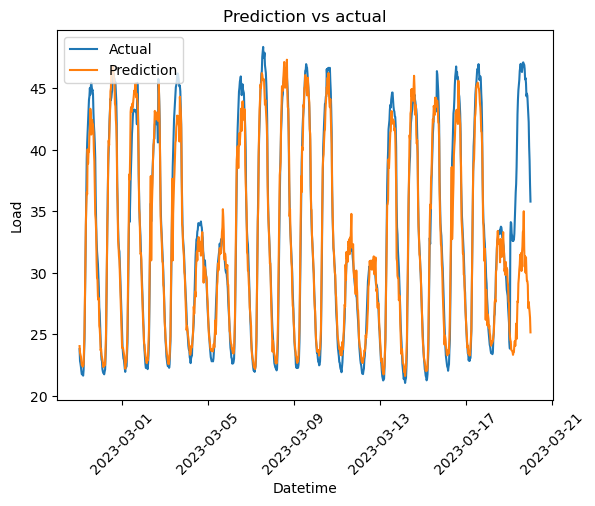

In [118]:
#visualization 
df_to_vis = main_xgb_pred_df_0_1.filter((weekofyear(col('Datetime'))>=9)&(weekofyear(col('Datetime'))<=11))
x = np.array(df_to_vis.select("Datetime").collect()).flatten()
y1 = np.array(df_to_vis.select("Load").collect()).flatten()
y2 = np.array(df_to_vis.select("prediction").collect()).flatten()
plt.plot(x, y1, label="Actual")
plt.plot(x, y2, label="Prediction")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.title("Prediction vs actual")
plt.legend()
plt.xticks(rotation=45)

2024-05-20 20:37:31,722 WARNING SparkXGBRegressor: _validate_gpu_params You have enabled GPU in spark local mode. Please make sure your local node has at least 1 GPUs
2024-05-20 20:38:59,802 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cuda', 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 25, 'verbosity': 0, 'num_round': 50, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-05-20 20:40:30,320 INFO SparkXGBRegressor: _skip_stage_level_scheduling Stage-level scheduling in xgboost requires spark standalone or local-cluster mode
2024-05-20 20:40:37,141 INFO XGBoost-PySpark: _fit Finished xgboost training!


<Axes: xlabel='Feature'>

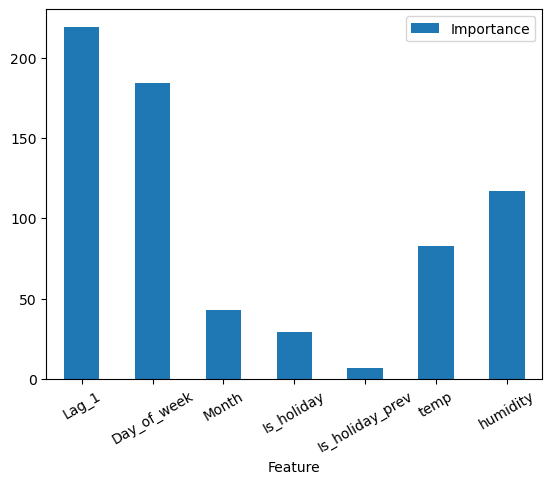

In [171]:
#Check Feature Importance
data = df_list[20].dropna()
features = ['Lag_1','Day_of_week','Month','Is_holiday','Is_holiday_prev','temp','humidity']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)
#load best params
with open('dataset/bestparams.json', 'r') as json_file:
    bestparams = json.load(json_file)
#split
train_data = data.filter(year(col("Date")) <= 2022)
test_data = data.filter(year(col("Date")) > 2022)    
#create model
xgb_regressor = SparkXGBRegressor(
    features_col="features",
    label_col="Load",
    device="cuda",
    objective='reg:squarederror',
    num_round=50,
    learning_rate=bestparams['20']['eta'],
    max_depth=bestparams['20']['max_depth'],
    reg_lambda=bestparams['20']['lambda'],
    verbosity=0)
#train
xgb_model_check = xgb_regressor.fit(train_data) 
feature_importance = xgb_model_check.get_feature_importances()
fi_df = pd.DataFrame({'Feature':features, 'Importance':[0]*len(features)})
for i in range(len(features)):
    if f'f{i}' in feature_importance.keys():
        fi_df.loc[i,'Importance'] = feature_importance[f'f{i}']
fi_df.plot.bar(x='Feature', y='Importance', rot=30)       

Text(0.5, 1.0, 'Distribution Plot of Absolute Error')

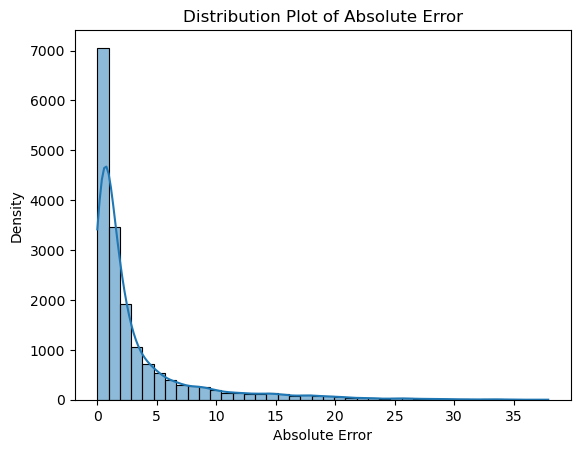

In [188]:
#Error explopration - histogram
main_xgb_pred_pd_df_0_1 = main_xgb_pred_df_0_1.toPandas()
sns.histplot(main_xgb_pred_pd_df_0_1['abs_error'], kde=True, bins=40)  
plt.xlabel('Absolute Error')
plt.ylabel('Density')
plt.title('Distribution Plot of Absolute Error')

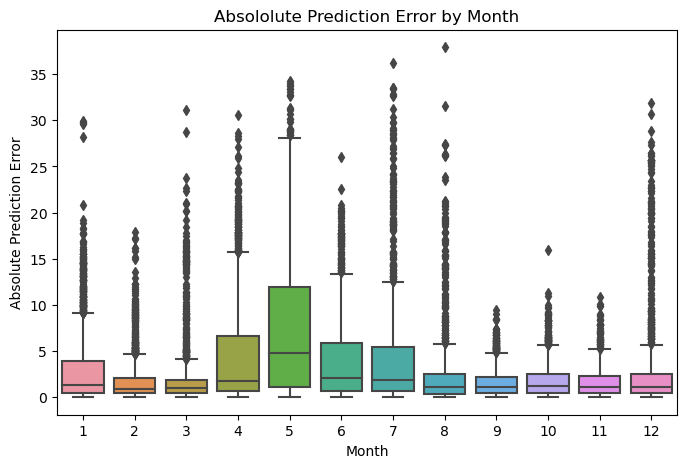

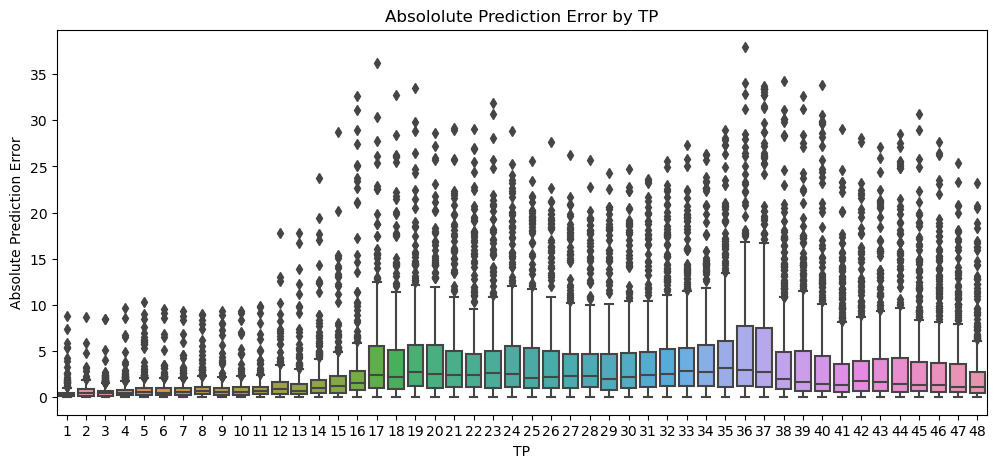

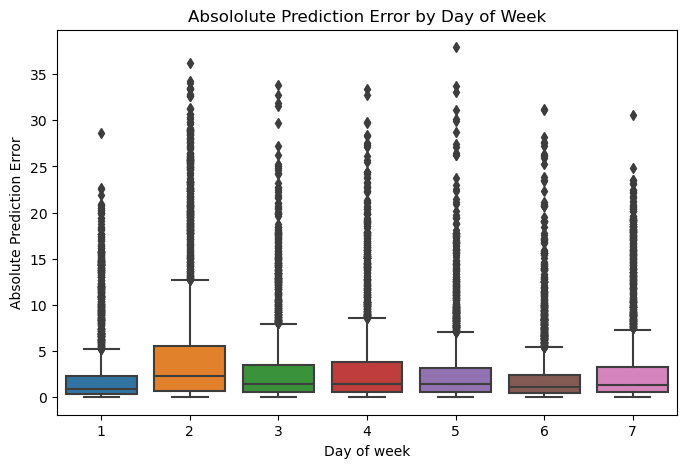

In [173]:
# Plot Absolute Error on Different Features
plt.figure(figsize=(8,5))
sns.boxplot(x='Month', y='abs_error', data=main_xgb_pred_pd_df_0_1)
plt.xlabel('Month')
plt.ylabel('Absolute Prediction Error')
plt.title('Absololute Prediction Error by Month')
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='TP', y='abs_error', data=main_xgb_pred_pd_df_0_1)
plt.xlabel('TP')
plt.ylabel('Absolute Prediction Error')
plt.title('Absololute Prediction Error by TP')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Day_of_week', y='abs_error', data=main_xgb_pred_pd_df_0_1)
plt.xlabel('Day of week')
plt.ylabel('Absolute Prediction Error')
plt.title('Absololute Prediction Error by Day of Week')
plt.show()


In [189]:
main_xgb_pred_pd_df_0_1.head(200)

,Date,TP,Datetime,idx,time,Load,Day_of_week,Month,Is_weekend,Is_holiday,temp,humidity,Is_holiday_prev,prediction,abs_error,absp_error
0,2023-01-01,1,2023-01-01 00:00:00,0,00:00:00,11.45,1,1,1,1,18.9,84.06,0,12.253802,0.803802,0.070201
1,2023-01-01,2,2023-01-01 00:30:00,1,00:30:00,11.91,1,1,1,1,18.9,84.06,0,12.713692,0.803692,0.067480
2,2023-01-01,3,2023-01-01 01:00:00,2,01:00:00,12.05,1,1,1,1,18.8,83.99,0,13.257768,1.207768,0.100230
3,2023-01-01,4,2023-01-01 01:30:00,3,01:30:00,12.16,1,1,1,1,18.8,83.99,0,11.920226,0.239774,0.019718
4,2023-01-01,5,2023-01-01 02:00:00,4,02:00:00,12.47,1,1,1,1,18.0,74.87,0,13.279854,0.809854,0.064944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2023-01-05,4,2023-01-05 01:30:00,195,01:30:00,11.43,5,1,0,0,18.8,95.04,0,12.562288,1.132288,0.099063
196,2023-01-05,5,2023-01-05 02:00:00,196,02:00:00,11.46,5,1,0,0,18.1,99.23,0,12.470972,1.010972,0.088217
197,2023-01-05,6,2023-01-05 02:30:00,197,02:30:00,11.80,5,1,0,0,18.1,99.23,0,13.096530,1.296530,0.109875
198,2023-01-05,7,2023-01-05 03:00:00,198,03:00:00,11.78,5,1,0,0,18.1,99.48,0,13.077230,1.297230,0.110121


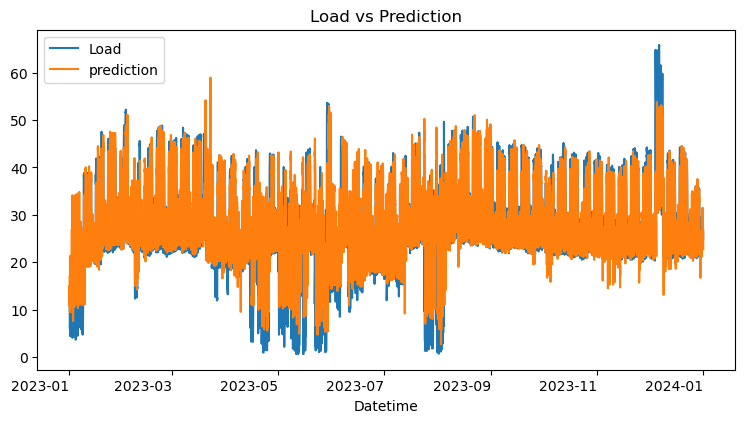

In [181]:
#Prediction result pattern
main_xgb_pred_pd_df_0_1.plot.line(x='Datetime',y=['Load','prediction'],figsize=(9,5),rot=0)
plt.title('Load vs Prediction')
plt.legend()

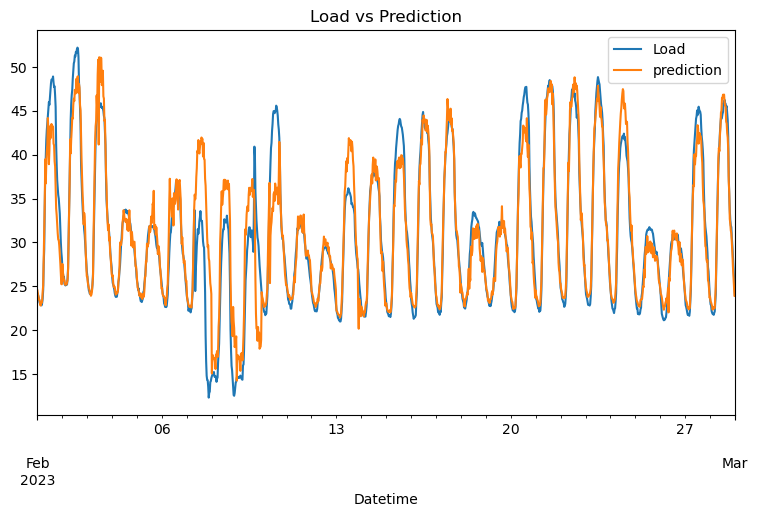

In [184]:
#month scale
df_to_plot = main_xgb_pred_pd_df_0_1[(main_xgb_pred_pd_df_0_1['Datetime']<='2023-03-01')&(main_xgb_pred_pd_df_0_1['Datetime']>='2023-02-01')]
df_to_plot.plot.line(x='Datetime',y=['Load','prediction'],figsize=(9,5),rot=0)
plt.title('Load vs Prediction')
plt.legend()

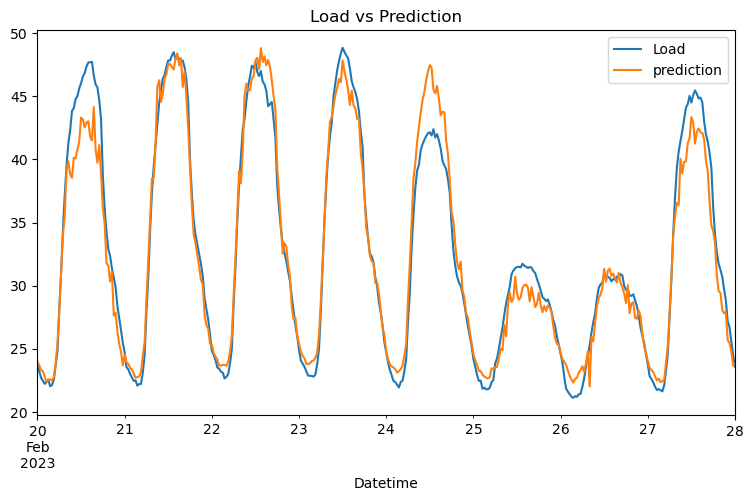

In [186]:
#week scale
df_to_plot = main_xgb_pred_pd_df_0_1[(main_xgb_pred_pd_df_0_1['Datetime']<='2023-02-28')&(main_xgb_pred_pd_df_0_1['Datetime']>='2023-02-20')]
df_to_plot.plot.line(x='Datetime',y=['Load','prediction'],figsize=(9,5),rot=0)
plt.title('Load vs Prediction')
plt.legend()

C:\Users\boypa\AppData\Local\Temp\ipykernel_428496\3189449609.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='TP', y='prediction', data=main_xgb_pred_pd_df_0_1, hue='Month', ci=None)
C:\Users\boypa\AppData\Local\Temp\ipykernel_428496\3189449609.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='TP', y='prediction', data=main_xgb_pred_pd_df_0_1, hue='Day_of_week', ci=None)


<Axes: xlabel='TP', ylabel='prediction'>

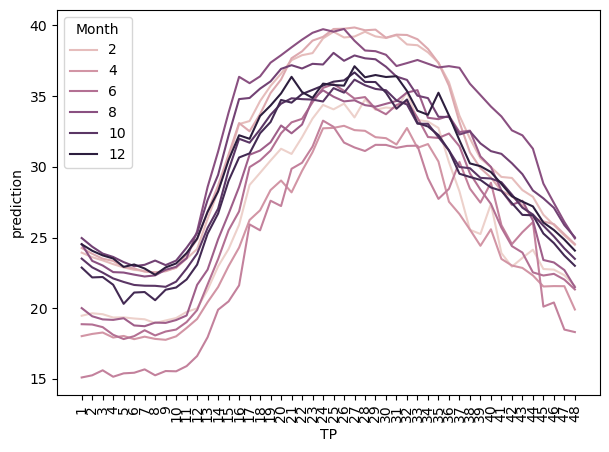

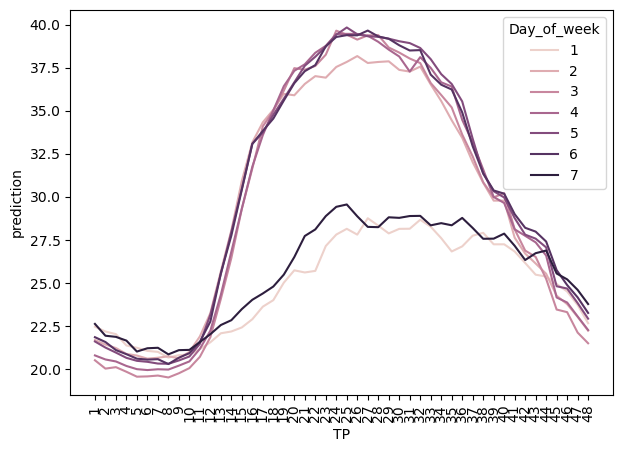

In [187]:
# Check Result of DM
#TP and Load
plt.figure(figsize=(7,5))
plt.xticks(rotation=90)
sns.lineplot(x='TP', y='prediction', data=main_xgb_pred_pd_df_0_1, hue='Month', ci=None)

#----------------------------------------------#
#Day of the week and Load
plt.figure(figsize=(7,5))
plt.xticks(rotation=90)
sns.lineplot(x='TP', y='prediction', data=main_xgb_pred_pd_df_0_1, hue='Day_of_week', ci=None)


***Model XGB3: Time-lag Feature Scenario 2 With Parameter Tuning and Drop Month and Humidity*** 

In [ ]:
#Do predictions for TP1 to TP48 (Use multiple time-lag features and use best parameters) 
#Export each to csv to avoid loosing data in the process as it took sometime to complete all prediction target 
features_in = ['Lag_1','Lag_2','Day_of_week','Is_holiday','Is_holiday_prev','temp']
with open('dataset/bestparams.json', 'r') as json_file:
    bestparams = json.load(json_file)
for i in range(1,49):
    print(f'Start training and testing for TP{i}')
    df = df_list[i]
    params=bestparams[f'{i}']
    xgb_pred = xgb_model(df,features_in,params)
    df_to_merge = xgb_pred.select('prediction','TP','Date')
    df_to_merge.toPandas().to_csv(f'predictions/xgb_pred{i}.csv')
    print(f'Finish training and testing for TP{i}')

In [102]:
#retrieve multiple prediction target, merge to a df
main_xgb_pred_df = main_df.filter(year(col('Date'))>2022)
schema = StructType([
    StructField("Date", DateType(), True),
    StructField("TP", IntegerType(), True),
    StructField("prediction", DoubleType(), True)])
df_tomerge = spark.createDataFrame([], schema)
for i in range(1,49):
    df_pred=spark.read.csv(f'predictions/xgb_pred{i}.csv', header=True, inferSchema=True).select('Date','TP','prediction')
    df_tomerge=df_tomerge.union(df_pred)
main_xgb_pred_df_2 = main_xgb_pred_df.join(df_tomerge, on=["Date", "TP"], how="left")

In [103]:
#add error columns and calculate overall performance
main_xgb_pred_df_2 = main_xgb_pred_df_2.dropna().withColumn("abs_error", spark_abs(col('Load') - col("prediction")))
main_xgb_pred_df_2 = main_xgb_pred_df_2.dropna().withColumn("absp_error", spark_abs(col('Load') - col("prediction")) / col('Load'))
total_count = main_xgb_pred_df_2.select('prediction').count()
xgb_mape_15 = (main_xgb_pred_df_2.filter(col("absp_error") < 0.15).count())/total_count
mae = main_xgb_pred_df_2.select(avg("abs_error")).first()[0]
mape = main_xgb_pred_df_2.select(avg("absp_error")).first()[0]

In [104]:
print(f'MAPE : {mape}') #Mean average percentage error
print(f'Proportion APE<15% : {xgb_mape_15}') #Proportion of absolute percentage error less than 15%
print(f'MAE : {mae}')#Mean Absolute Error

MAPE : 0.19622051965513176
Proportion APE<15% : 0.830365296803653
MAE : 2.530805688635964


(array([19417., 19421., 19425., 19429., 19433., 19437.]),
 [Text(19417.0, 0, '2023-03-01'),
  Text(19421.0, 0, '2023-03-05'),
  Text(19425.0, 0, '2023-03-09'),
  Text(19429.0, 0, '2023-03-13'),
  Text(19433.0, 0, '2023-03-17'),
  Text(19437.0, 0, '2023-03-21')])

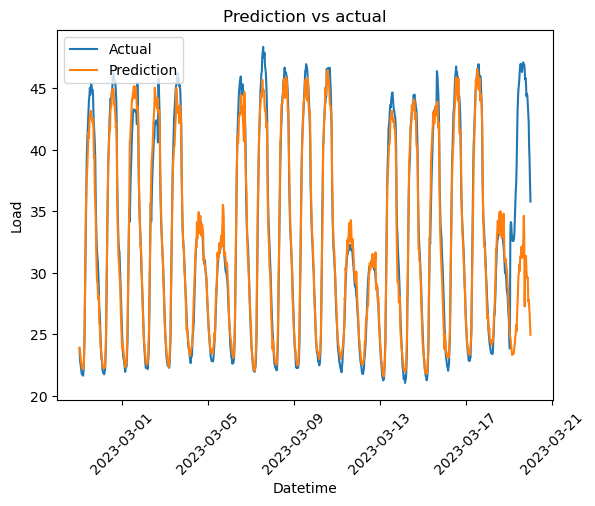

In [106]:
#Visualize 
df_to_vis = main_xgb_pred_df_2.filter((weekofyear(col('Datetime'))>=9)&(weekofyear(col('Datetime'))<=11))
x = np.array(df_to_vis.select("Datetime").collect()).flatten()
y1 = np.array(df_to_vis.select("Load").collect()).flatten()
y2 = np.array(df_to_vis.select("prediction").collect()).flatten()
plt.plot(x, y1, label="Actual")
plt.plot(x, y2, label="Prediction")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.title("Prediction vs actual")
plt.legend()
plt.xticks(rotation=45)

***Model XGB4: Time-lag Feature Scenario 2 With Parameter Tuning, Drop Weather Features*** 

In [ ]:
#Do predictions for TP1 to TP48 (Use multiple time-lag features and use best parameters, drop weather features) 
features_in = ['Lag_1','Lag_2','Day_of_week','Month','Is_holiday','Is_holiday_prev']
with open('dataset/bestparams.json', 'r') as json_file:
    bestparams = json.load(json_file)
for i in range(1,49):
    print(f'Start training and testing for TP{i}')
    df = df_list[i]
    params=bestparams[f'{i}']
    xgb_pred_1 = xgb_model(df,features_in,params)
    df_to_merge_1 = xgb_pred_1.select('prediction','TP','Date')
    df_to_merge_1.toPandas().to_csv(f'predictions/1_xgb_pred{i}.csv')
    print(f'Finish training and testing for TP{i}')

In [109]:
#retrieve multiple prediction target, merge to a df
main_xgb_pred_df = main_df.filter(year(col('Date'))>2022)
schema = StructType([
    StructField("Date", DateType(), True),
    StructField("TP", IntegerType(), True),
    StructField("prediction", DoubleType(), True)])
df_tomerge = spark.createDataFrame([], schema)
for i in range(1,49):
    df_pred=spark.read.csv(f'predictions/1_xgb_pred{i}.csv', header=True, inferSchema=True).select('Date','TP','prediction')
    df_tomerge=df_tomerge.union(df_pred)
main_xgb_pred_df_1 = main_xgb_pred_df.join(df_tomerge, on=["Date", "TP"], how="left")

In [110]:
#add error columns and calculate overall performance
main_xgb_pred_df_1 = main_xgb_pred_df_1.dropna().withColumn("abs_error", spark_abs(col('Load') - col("prediction")))
main_xgb_pred_df_1 = main_xgb_pred_df_1.dropna().withColumn("absp_error", spark_abs(col('Load') - col("prediction")) / col('Load'))
total_count = main_xgb_pred_df_1.select('prediction').count()
xgb_mape_15_1 = (main_xgb_pred_df_1.filter(col("absp_error") < 0.15).count())/total_count
mae_1 = main_xgb_pred_df_1.select(avg("abs_error")).first()[0]
mape_1 = main_xgb_pred_df_1.select(avg("absp_error")).first()[0]

In [111]:
print(f'MAPE : {mape_1}') #Mean average percentage error
print(f'Proportion APE<15% : {xgb_mape_15_1}') #Proportion of absolute percentage error less than 15%
print(f'MAE : {mae_1}')#Mean Absolute Error

MAPE : 0.2295211004683231
Proportion APE<15% : 0.8230593607305936
MAE : 2.6840496285056865


(array([19417., 19421., 19425., 19429., 19433., 19437.]),
 [Text(19417.0, 0, '2023-03-01'),
  Text(19421.0, 0, '2023-03-05'),
  Text(19425.0, 0, '2023-03-09'),
  Text(19429.0, 0, '2023-03-13'),
  Text(19433.0, 0, '2023-03-17'),
  Text(19437.0, 0, '2023-03-21')])

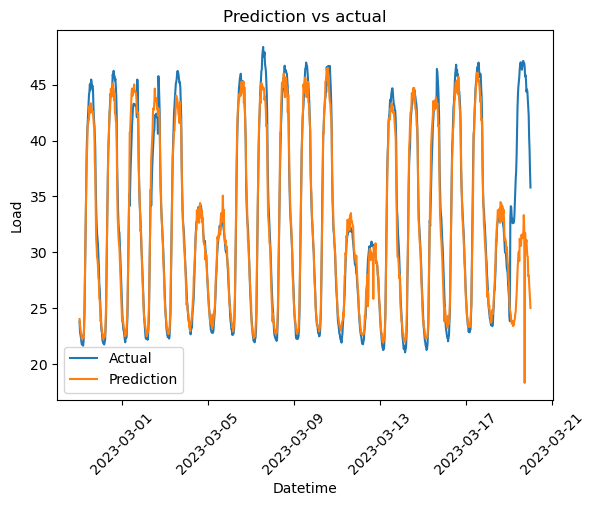

In [112]:
#Visualize
df_to_vis = main_xgb_pred_df_1.filter((weekofyear(col('Datetime'))>=9)&(weekofyear(col('Datetime'))<=11))
x = np.array(df_to_vis.select("Datetime").collect()).flatten()
y1 = np.array(df_to_vis.select("Load").collect()).flatten()
y2 = np.array(df_to_vis.select("prediction").collect()).flatten()
plt.plot(x, y1, label="Actual")
plt.plot(x, y2, label="Prediction")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.title("Prediction vs actual")
plt.legend()
plt.xticks(rotation=45)

***Random Forest Model*** 

In [89]:
dt_df = main_df
dt_df=dt_df.withColumn("TP",col("TP").cast(IntegerType())) 
dt_df=dt_df.withColumn("Is_holiday",col("Is_holiday").cast(IntegerType()))
dt_df=dt_df.withColumn("Is_holiday_prev",col("Is_holiday_prev").cast(IntegerType())) 
#Add lag_1 = observation at the same time yesterday
w = Window.orderBy("Datetime")
dt_df = dt_df.withColumn("Lag_1",lag('Load', 48).over(w))
#Add lag_2 = last observation on previous day
load_48 = dt_df.filter(col('TP')==48).select('Date','Load')
w2 = Window.orderBy("Date")
load_48_prev = load_48.withColumn('Lag_2', lag('Load', 1).over(w2)).drop('Load').withColumnRenamed('Date','Date_48')
dt_df = dt_df.join(load_48_prev,dt_df['Date']==load_48_prev['Date_48'],how='left').drop('Date_48')

indexers = [StringIndexer(inputCol="Month", outputCol="Month_index"),
            StringIndexer(inputCol="TP", outputCol="TP_index"),
            StringIndexer(inputCol="Day_of_week", outputCol="Day_week_index"),
            StringIndexer(inputCol="Is_holiday", outputCol="Is_holiday_index"),
            StringIndexer(inputCol="Is_holiday_prev", outputCol="Is_holiday_prev_index")]
    
encoders = [OneHotEncoder(inputCol="Month_index", outputCol="Month_encoded"),
            OneHotEncoder(inputCol="TP_index", outputCol="TP_encoded"),
            OneHotEncoder(inputCol="Day_week_index", outputCol="Day_week_encoded"),
            OneHotEncoder(inputCol="Is_holiday_index", outputCol="Is_holiday_encoded"),
            OneHotEncoder(inputCol="Is_holiday_prev_index", outputCol="Is_holiday_prev_encoded")]

assemblerInputs = [encoder.getOutputCol() for encoder in encoders] +["Lag_1","Lag_2"] 
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")
#Build Model 
rf = RandomForestRegressor(featuresCol='features', labelCol='Load', numTrees=75, maxDepth=8)
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])
train_data = dt_df.filter((col("Date") < "2023-01-01")&(col("Date") > "2021-01-01"))
test_data = dt_df.filter(col("Date") >= "2023-01-01")
rf_model = pipeline.fit(train_data)
pred_rf = rf_model.transform(test_data)

In [91]:
#retrieve multiple prediction target, merge to a df
pred_df_rf = pred_rf.select('Datetime','Date','TP','Day_of_week','Load','prediction','Is_holiday')
#add error columns and calculate overall performance
pred_df_rf = pred_df_rf.dropna().withColumn("abs_error", spark_abs(col('Load') - col("prediction")))
pred_df_rf = pred_df_rf.dropna().withColumn("absp_error", spark_abs(col('Load') - col("prediction")) / col('Load'))
total_count = pred_df_rf.select('prediction').count()
rf_mape_15 = (pred_df_rf.filter(col("absp_error") < 0.15).count())/total_count
rf_mae = pred_df_rf.select(avg("abs_error")).first()[0]
rf_mape = pred_df_rf.select(avg("absp_error")).first()[0]

In [92]:
print(f'MAPE : {rf_mape}') #Mean average percentage error
print(f'Proportion APE<15% : {rf_mape_15}') #Proportion of absolute percentage error less than 15%
print(f'MAE : {rf_mae}')#Mean Absolute Error

MAPE : 0.27610125677149505
Proportion APE<15% : 0.7278538812785388
MAE : 3.798403351505818


(array([19417., 19421., 19425., 19429., 19433., 19437.]),
 [Text(19417.0, 0, '2023-03-01'),
  Text(19421.0, 0, '2023-03-05'),
  Text(19425.0, 0, '2023-03-09'),
  Text(19429.0, 0, '2023-03-13'),
  Text(19433.0, 0, '2023-03-17'),
  Text(19437.0, 0, '2023-03-21')])

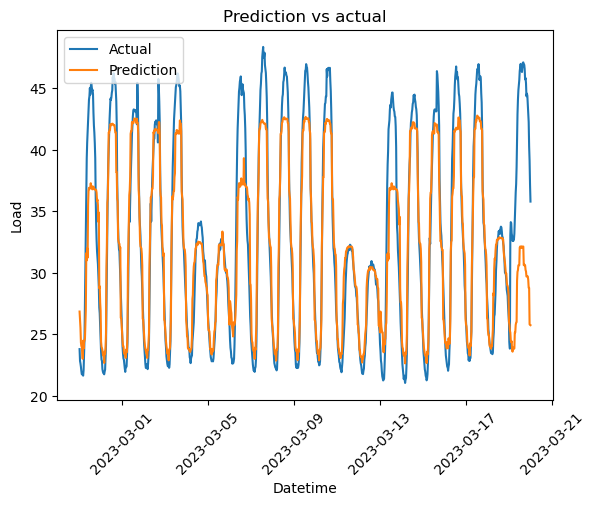

In [93]:
#Visualize
df_to_vis = pred_df_rf.filter((weekofyear(col('Datetime'))>=9)&(weekofyear(col('Datetime'))<=11))
x = np.array(df_to_vis.select("Datetime").collect()).flatten()
y1 = np.array(df_to_vis.select("Load").collect()).flatten()
y2 = np.array(df_to_vis.select("prediction").collect()).flatten()
plt.plot(x, y1, label="Actual")
plt.plot(x, y2, label="Prediction")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.title("Prediction vs actual")
plt.legend()
plt.xticks(rotation=45)